# Recommendation System

Oleh: Junianto Endra Kartika

## Import Library

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, regularizers

## Data Loading

Dataset yang digunakan bernama [MovieLens](https://grouplens.org/datasets/movielens/) dengan total data yang ada adalah 100 ribu data.

### Users

In [ ]:
# Memuat data user

user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Dataset/ml-100k/u.user', sep='|', header=None, names=user_cols, engine='python', encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# Menampilkan jumlah pengguna

n_users = users.shape[0]
print(f'Jumlah pengguna: {n_users}')

Jumlah pengguna: 943


### Genres

In [ ]:
# Memuat data genre

genre_cols = ['genre_name', 'genre_id']
genres = pd.read_csv('../Dataset/ml-100k/u.genre', sep='|', header=None, names=genre_cols, engine='python', encoding='latin-1')
genres.head()

,genre_name,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [ ]:
# Menampilkan jumlah genre

n_genres = genres.shape[0]
print(f'Jumlah genre: {n_genres}')

Jumlah genre: 19


### Movies

In [ ]:
# Memuat data movie

movie_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
movie_cols += genres['genre_name'].tolist()

movies = pd.read_csv('../Dataset/ml-100k/u.item', sep='|', header=None, names=movie_cols, engine='python', encoding='latin-1')

# Menampilkan 5 data movie pertama
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Menampilkan 5 data movie terakhir
movies.tail()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Menampilkan jumlah movie

n_movies = movies.shape[0]
print(f'Jumlah movies: {n_movies}')

Jumlah movies: 1682


### Ratings

In [ ]:
# Memuat data rating

rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('../Dataset/ml-100k/ua.base', sep='\t', header=None, names=rating_cols, engine='python', encoding='latin-1')
ratings_test = pd.read_csv('../Dataset/ml-100k/ua.test', sep='\t', header=None, names=rating_cols, engine='python', encoding='latin-1')

ratings_base.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
# Menampilkan jumlah rating

n_train = ratings_base.values
n_test = ratings_test.values

print(f'Jumlah rating train: {n_train.shape[0]}')
print(f'Jumlah rating test: {n_test.shape[0]}')

Jumlah rating train: 90570
Jumlah rating test: 9430


Pada proyek ini, akan terdapat beberapa data yang akan digunakan. Yaitu

1. Users:
    - `user_id`
    - `age`
    - `occupation`
    - `zip_code`
2. Genres
    - `genre_id`
    - `genre_name`
3. Movies
    - `movie_id`
    - `movie_title`
    - `release_date`
    - `video_release_date`
    - `IMDb_URL`
    - One-hot genres encoding
4. Ratings
    - `user_id`
    - `movie_id`
    - `rating`
    - `unix_timestamp`

## EDA

### Users

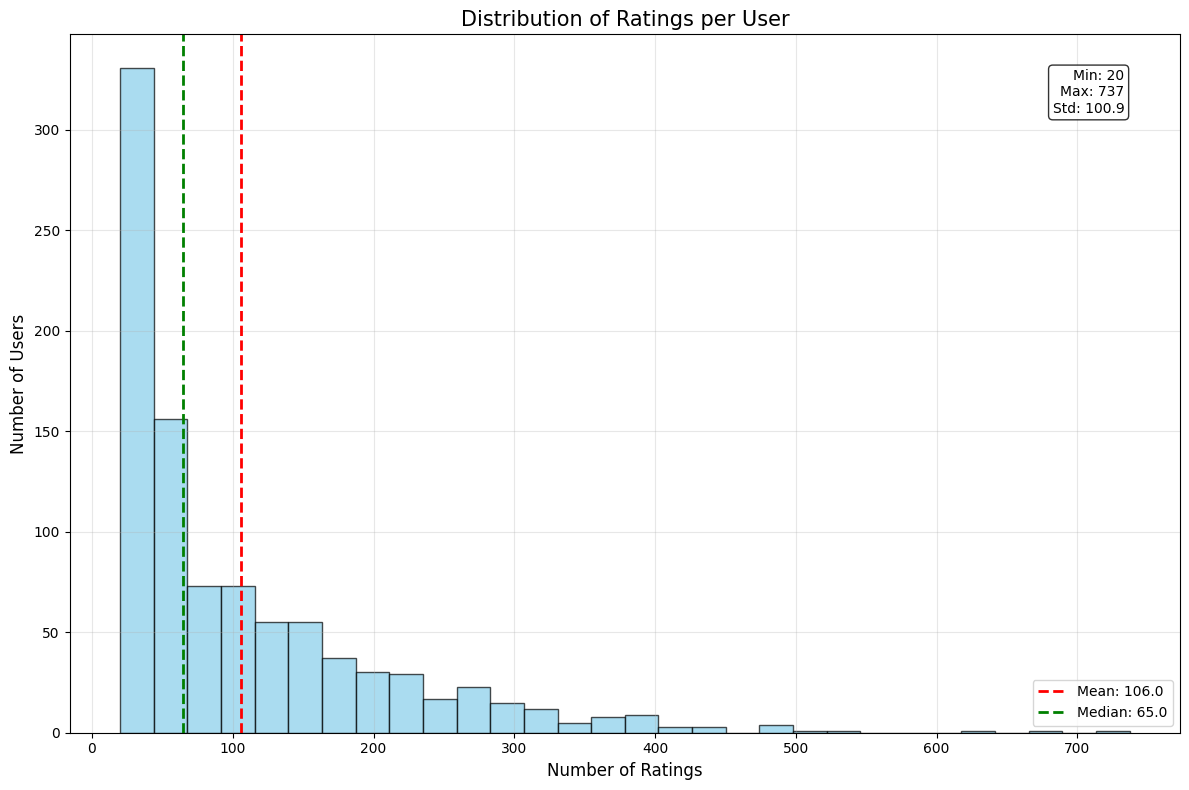

Total number of users: 943
Total number of ratings: 100000
Average number of ratings per user: 106.04
Maximum number of ratings by a user: 737
Minimum number of ratings by a user: 20


In [ ]:
# Menggabungkan peringkat dari kumpulan data dasar dan uji
all_ratings = pd.concat([ratings_base, ratings_test])

# Menghitung rating per pengguna
ratings_per_user = all_ratings.groupby('user_id')['rating'].count()

# Menghitung statistik
min_ratings = ratings_per_user.min()
max_ratings = ratings_per_user.max()
mean_ratings = ratings_per_user.mean()
median_ratings = ratings_per_user.median()
std_ratings = ratings_per_user.std()

# Menampilkan statistik
plt.figure(figsize=(12, 8))

n, bins, patches = plt.hist(ratings_per_user, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

plt.axvline(mean_ratings, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ratings:.1f}')
plt.axvline(median_ratings, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_ratings:.1f}')

stats_text = f'Min: {min_ratings}\nMax: {max_ratings}\nStd: {std_ratings:.1f}'
plt.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
             ha='right', va='top')

plt.title('Distribution of Ratings per User', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Menampilkan informasi pengguna
print(f"Total number of users: {len(ratings_per_user)}")
print(f"Total number of ratings: {len(all_ratings)}")
print(f"Average number of ratings per user: {mean_ratings:.2f}")
print(f"Maximum number of ratings by a user: {max_ratings}")
print(f"Minimum number of ratings by a user: {min_ratings}")

### Genres

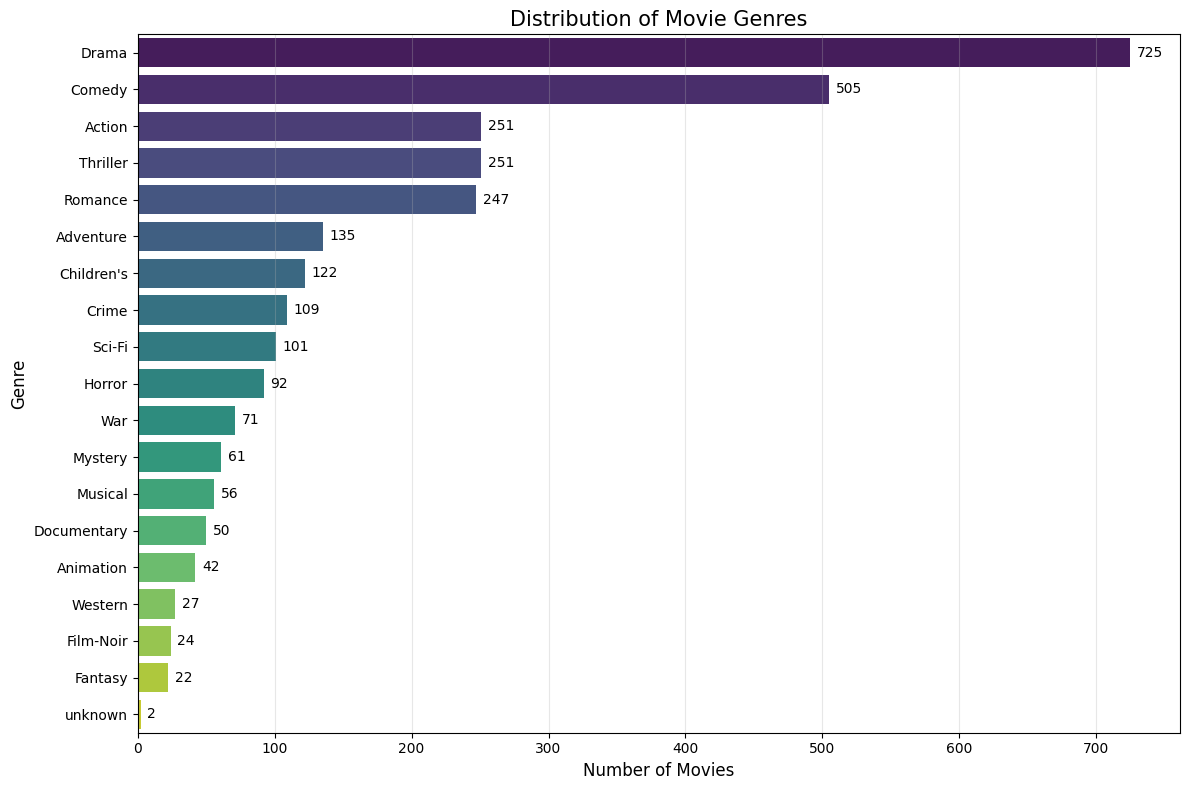

Total number of genre assignments: 2893
Average genres per movie: 1.72
Most common genre: Drama (725 movies)
Least common genre: unknown (2 movies)


In [ ]:
# Menghitung jumlah film untuk setiap genre
genre_counts = {}
genre_columns = [col for col in movies.columns if col not in ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']]
for genre in genre_columns:
    genre_counts[genre] = movies[genre].sum()

# Menghitung total film untuk setiap genre
genre_distribution = pd.Series(genre_counts).sort_values(ascending=False)

# Menampilkan distribusi genre
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=genre_distribution.values, y=genre_distribution.index, hue=genre_distribution.index, palette='viridis', legend=False)

for i, v in enumerate(genre_distribution.values):
    ax.text(v + 5, i, f"{int(v)}", va='center')

plt.title('Distribution of Movie Genres', fontsize=15)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Menampilkan informasi genre
print(f"Total number of genre assignments: {sum(genre_distribution.values)}")
print(f"Average genres per movie: {sum(genre_distribution.values) / n_movies:.2f}")
print(f"Most common genre: {genre_distribution.index[0]} ({int(genre_distribution.values[0])} movies)")
print(f"Least common genre: {genre_distribution.index[-1]} ({int(genre_distribution.values[-1])} movies)")

In [ ]:
# Mencari film dengan genre 'unknown'
unknown_movies = movies[movies['unknown'] == 1]
print(f"Number of movies with 'unknown' genre: {len(unknown_movies)}")

# Mencari film dengan genre 'unknown' dan genre lain
genre_columns = [col for col in movies.columns if col not in ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown']]
has_other_genres = unknown_movies[genre_columns].sum(axis=1) > 0

# Menampilkan film dengan genre 'unknown' dan genre lain
unknown_movies_details = unknown_movies[['movie_id', 'movie_title', 'release_date']]
print("\nDetails of unknown genre movies:")
print(unknown_movies_details)

# Menampilkan jumlah film dengan genre 'unknown' dan genre lain
print(f"\nMovies with 'unknown' genre that also have other genres: {has_other_genres.sum()}")
print(f"Movies with ONLY 'unknown' genre: {(~has_other_genres).sum()}")

Number of movies with 'unknown' genre: 2

Details of unknown genre movies:
      movie_id          movie_title release_date
266        267              unknown          NaN
1372      1373  Good Morning (1971)   4-Feb-1971

Movies with 'unknown' genre that also have other genres: 0
Movies with ONLY 'unknown' genre: 2


Karena hanya 2 movie yang memiliki genre `unknown` dan movie tersebut tidak memiliki genre yang lain, maka movie tersebut akan dihapus dari data untuk menjaga keseimbangan data.

In [ ]:
# Menghapus film dengan genre 'unknown' yang tidak memiliki genre lain
movie_ids_to_remove = unknown_movies[~has_other_genres]['movie_id'].tolist()
movies = movies[~movies['movie_id'].isin(movie_ids_to_remove)]

# Menghapus kolom 'unknown' dari DataFrame movies
movies = movies.drop('unknown', axis=1)

# Menghapus genre 'unknown' dari DataFrame genres
genre_columns = [col for col in movies.columns if col not in ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']]

# Menghapus kolom 'unknown' dari genre_cols
if 'unknown' in movie_cols:
    movie_cols.remove('unknown')

# Menghapus genre 'unknown' dari DataFrame genres
genres = genres[genres['genre_name'] != 'unknown']

print(f"Menghapus {len(movie_ids_to_remove)} movies dengen gener 'unknown'.")
print(f"Jumlah movies setelah penghapusan: {movies.shape[0]}")
print(f"Jumlah genres setelah penghapusan 'unknown': {len(genres)}")

Menghapus 2 movies dengen gener 'unknown'.
Jumlah movies setelah penghapusan: 1680
Jumlah genres setelah penghapusan 'unknown': 18


### Ratings

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10208\678477160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis', legend=False)


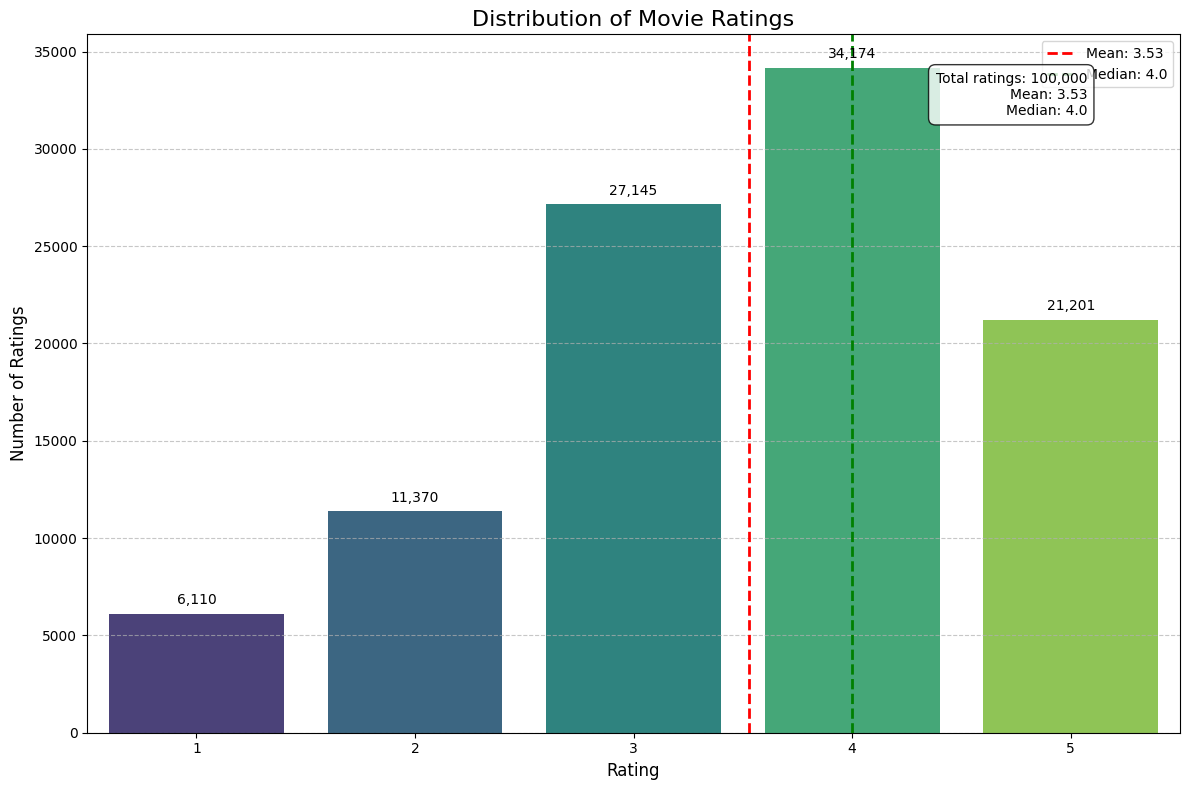

In [ ]:
plt.figure(figsize=(12, 8))

# Menampilkan distribusi rating
rating_counts = all_ratings['rating'].value_counts().sort_index()
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis', legend=False)

for i, count in enumerate(rating_counts.values):
	ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=10)

# Menambahkan statisik
mean_rating = all_ratings['rating'].mean()
median_rating = all_ratings['rating'].median()
total_ratings = len(all_ratings)

plt.axvline(x=mean_rating-1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
plt.axvline(x=median_rating-1, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.1f}')

plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.xticks(ticks=range(5), labels=['1', '2', '3', '4', '5'])

plt.figtext(0.91, 0.85, f"Total ratings: {total_ratings:,}\nMean: {mean_rating:.2f}\nMedian: {median_rating:.1f}", 
			bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
			horizontalalignment='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Data Preprocessing

### Menggabungkan Data

#### Content based data

In [ ]:
# Membuat fungsi untuk menyiapkan data untuk rekomendasi berbasis konten
def prepare_content_based_data():
    movie_features = movies.copy()
    
    # Membuat variable genre untuk setiap genre yang ada
    genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
                     'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    
    # Mengubah genre menjadi one-hot encoding
    content_df = movie_features[['movie_id', 'movie_title'] + genre_columns].copy()
    
    # Ubah kolom one-hot encoded genre menjadi kolom teks tunggal untuk pemrosesan TF-IDF
    content_df['genres'] = content_df[genre_columns].apply(
        lambda row: ' '.join([genre for genre, val in zip(genre_columns, row) if val == 1]), 
        axis=1
    )
    
    # Mereset indeks untuk menghindari masalah saat menggabungkan dengan rating
    content_df = content_df.reset_index(drop=True)
    
    return content_df, genre_columns

In [ ]:
# Memanggil fungsi dan menampilkan data
content_data, genre_columns = prepare_content_based_data()
content_data.head()

,movie_id,movie_title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,genres
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1995,Animation Children's Comedy
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995,Action Adventure Thriller
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995,Thriller
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1995,Action Comedy Drama
4,5,Copycat (1995),0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1995,Crime Drama Thriller


#### Collaborative data

In [ ]:
# membuat fungsi untuk menyiapkan data untuk rekomendasi berbasis kolaboratif
def prepare_collaborative_data():
    cf_data = ratings_base.copy()
    cf_data = ratings_base.copy()
    
    # Menggabungkan dengan data pengguna
    cf_data_with_users = cf_data.merge(users[['user_id', 'age', 'sex', 'occupation']], on='user_id', how='left')
    
    # Menggabungkan dengan data film
    cf_data_with_movies = cf_data_with_users.merge(
        movies[['movie_id', 'movie_title']], 
        on='movie_id', 
        how='left'
    )
    
    # Membuat matriks interaksi pengguna-item (matriks rating pengguna-item)
    user_item_matrix = cf_data.pivot(index='user_id', columns='movie_id', values='rating')
    
    # Mendapatkan daftar semua ID pengguna dan ID film
    user_ids = cf_data['user_id'].unique().tolist()
    movie_ids = cf_data['movie_id'].unique().tolist()
    
    # Membuat pemetaan dari ID asli ke ID urutan (0 sampai n-1)
    user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
    movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    
    # Membuat pemetaan dari ID urutan kembali ke ID asli
    user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
    movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
    
    # Mengkonversi rating ke skala 0-1 (normalisasi)
    cf_data['rating'] = cf_data['rating'] / 5.0
    
    # Menggunakan ID terenkode untuk pengguna dan film
    cf_data['user_encoded'] = cf_data['user_id'].map(user_to_user_encoded)
    cf_data['movie_encoded'] = cf_data['movie_id'].map(movie_to_movie_encoded)
    
    return cf_data_with_movies, user_item_matrix, cf_data, user_encoded_to_user, movie_encoded_to_movie, len(user_ids), len(movie_ids)

# Memanggil fungsi
cf_merged_data, user_item_matrix, cf_data_processed, user_encoded_to_user, movie_encoded_to_movie, num_users, num_movies = prepare_collaborative_data()

In [ ]:
# Menampilkan 5 data teratas `cf_data_processed`
cf_data_processed.head()

,user_id,movie_id,rating,unix_timestamp,user_encoded,movie_encoded
0,1,1,1.0,874965758,0,0
1,1,2,0.6,876893171,0,1
2,1,3,0.8,878542960,0,2
3,1,4,0.6,876893119,0,3
4,1,5,0.6,889751712,0,4


## Data Preparation

### Mengatasi missing value

In [ ]:
# Mengecek apakah ada nilai yang hilang dalam data
content_data.isnull().sum()

movie_id        0
movie_title     0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
release_year    0
genres          0
dtype: int64

In [ ]:
# Mengecek apakah ada nilai yang hilang dalam data
cf_merged_data.isnull().sum()

user_id           0
movie_id          0
rating            0
unix_timestamp    0
age               0
sex               0
occupation        0
movie_title       9
dtype: int64

## Content Based Filtering

In [ ]:
# Membuat matriks TF-IDF untuk genre
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(content_data['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Menampilkan matriks TF-IDF
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=content_data['movie_title']
).sample(10, axis=1).sample(5, axis=0)

,war,drama,western,fi,mystery,action,children,horror,crime,comedy
movie_title,,,,,,,,,,
Grease (1978),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.385700
Dirty Dancing (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Home Alone (1990),0.0,0.0,0.0,0.0,0.0,0.0,0.854178,0.0,0.0,0.519981
Nell (1994),0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
"Mighty, The (1998)",0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
# Membuat fungsi untuk merekomendasikan film berdasarkan judul
def recommend(title, cosine_sim=cosine_sim):
    # Membuat pemetaan dari judul film ke indeks
    indices = pd.Series(content_data.index, index=content_data['movie_title']).drop_duplicates()
    
    try:
        # Mendapatkan indeks film yang sesuai dengan judul
        idx = indices[title]
        
        # Memeriksa apakah indeks berada dalam rentang yang valid
        if idx >= len(cosine_sim):
            print(f"Movie index {idx} is out of bounds (max valid index: {len(cosine_sim)-1})")
            return []
            
        print(f"Movie index: {idx}")
        
        # Mendapatkan skor kesamaan untuk semua film dengan film target
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]  # Mendapatkan 10 film serupa teratas kecuali film itu sendiri
        
        # Mendapatkan indeks film
        recommendations = [
            {
                'movie_id': content_data.iloc[i]['movie_id'],
                'movie_title': content_data.iloc[i]['movie_title'],
                'similarity': round(score, 4)
            }
            for i, score in sim_scores
        ]
        
        return recommendations
    except KeyError:
        print(f"Movie '{title}' not found in the dataset.")
        return []
    except IndexError as e:
        print(f"Index error: {e}. Movie index {idx} may be out of range.")
        return []
    except Exception as e:
        print(f"Error recommending movies: {str(e)}")
        return []

In [ ]:
# Membuat fungsi untuk menampilkan rekomendasi film
def visualize_recommendation(movie_title, recommendations, content_data):
    try:
        movie_idx = content_data[content_data['movie_title'] == movie_title].index[0]
        source_movie = content_data.iloc[movie_idx]
    except IndexError:
        print(f"Movie '{movie_title}' not found.")
        return

    if not recommendations or isinstance(recommendations, str):
        print("No recommendations available to visualize.")
        return

    rec_count = min(5, len(recommendations))
    movie_ids = [source_movie['movie_id']] + [rec['movie_id'] for rec in recommendations[:rec_count]]
    movies_to_compare = content_data[content_data['movie_id'].isin(movie_ids)]

    plt.figure(figsize=(12, 8))
    genre_profiles = movies_to_compare.set_index('movie_title')[genre_columns]

    sns.heatmap(genre_profiles.astype(float), cmap='viridis', cbar_kws={'label': 'Genre Present'})

    plt.title(f'Genre Profile Comparison: {movie_title} and Similar Movies', fontsize=15)
    plt.xlabel('Genres', fontsize=12)
    plt.ylabel('Movies', fontsize=12)
    plt.tight_layout()
    plt.show()

### Testing

Movie index: 0
Recommendations for 'Toy Story (1995)':
Aladdin and the King of Thieves (1996) (ID: 422) - Similarity: 1.0
Aristocats, The (1970) (ID: 102) - Similarity: 0.937
Pinocchio (1940) (ID: 404) - Similarity: 0.937
Sword in the Stone, The (1963) (ID: 625) - Similarity: 0.937
Fox and the Hound, The (1981) (ID: 946) - Similarity: 0.937
Winnie the Pooh and the Blustery Day (1968) (ID: 969) - Similarity: 0.937
Balto (1995) (ID: 1066) - Similarity: 0.937
Oliver & Company (1988) (ID: 1078) - Similarity: 0.937
Swan Princess, The (1994) (ID: 1409) - Similarity: 0.937
Land Before Time III: The Time of the Great Giving (1995) (V) (ID: 1412) - Similarity: 0.937


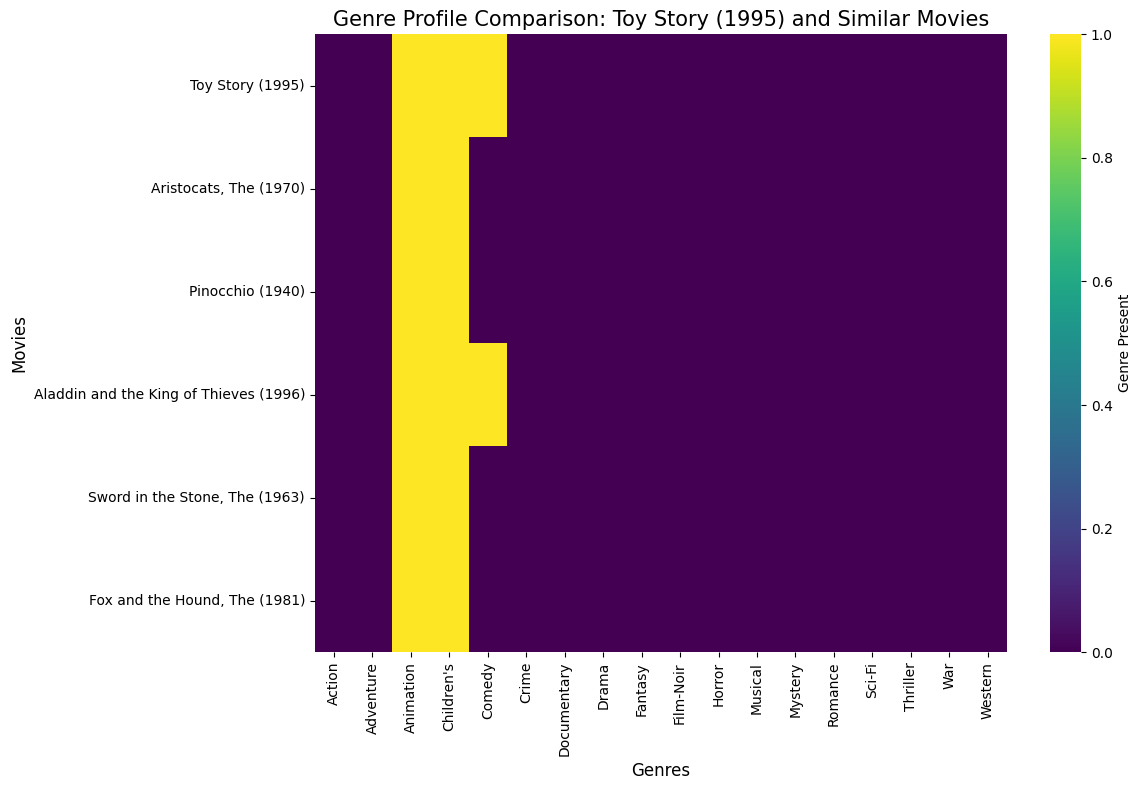

In [ ]:
toy_story_recommendations = recommend("Toy Story (1995)")

# Menampilkan rekomendasi
print("Recommendations for 'Toy Story (1995)':")
for rec in toy_story_recommendations:
    print(f"{rec['movie_title']} (ID: {rec['movie_id']}) - Similarity: {rec['similarity']}")

# Memvisualisasikan rekomendasi untuk Toy Story
visualize_recommendation("Toy Story (1995)", toy_story_recommendations, content_data)

Movie index: 1678

Recommendations for 'You So Crazy (1994)
Birdcage, The (1996) (ID: 25) - Similarity: 1.0
Brothers McMullen, The (1995) (ID: 26) - Similarity: 1.0
To Wong Foo, Thanks for Everything! Julie Newmar (1995) (ID: 40) - Similarity: 1.0
Billy Madison (1995) (ID: 41) - Similarity: 1.0
Clerks (1994) (ID: 42) - Similarity: 1.0
Ace Ventura: Pet Detective (1994) (ID: 67) - Similarity: 1.0
Ref, The (1994) (ID: 85) - Similarity: 1.0
Theodore Rex (1995) (ID: 104) - Similarity: 1.0
Sgt. Bilko (1996) (ID: 105) - Similarity: 1.0
Kids in the Hall: Brain Candy (1996) (ID: 108) - Similarity: 1.0


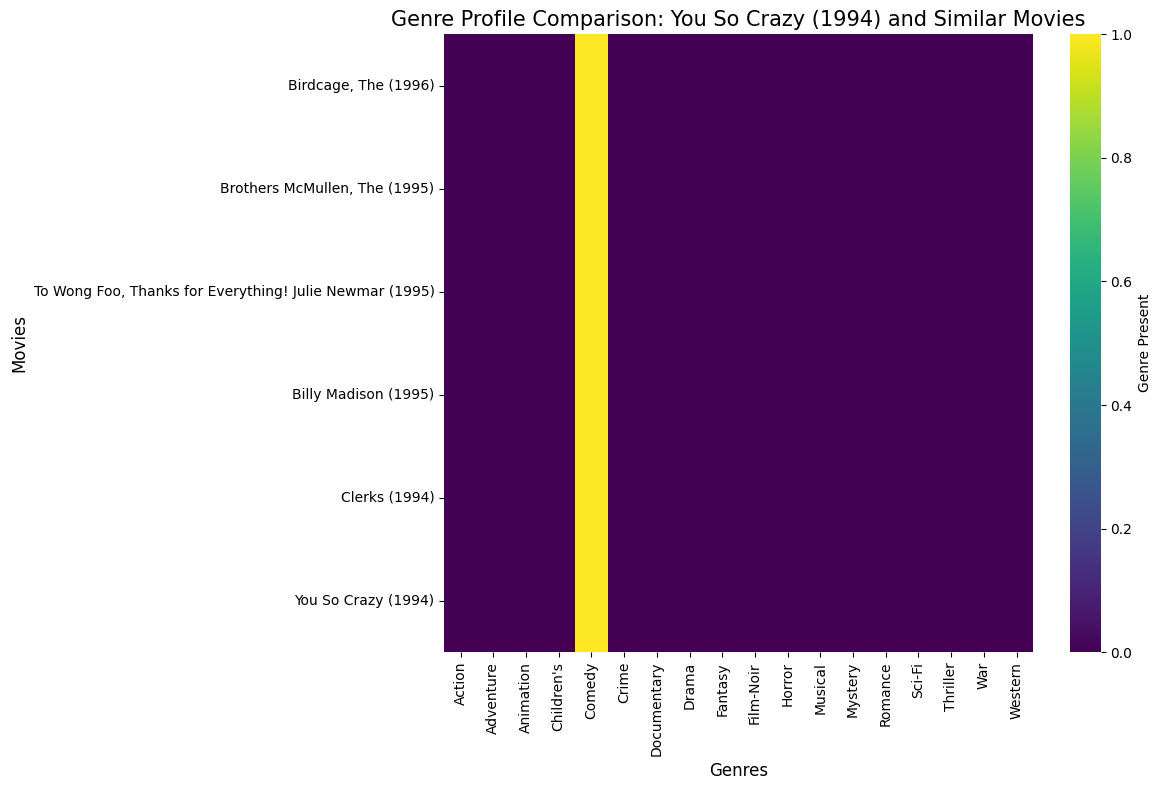

In [ ]:
you_so_crazy_recommendations = recommend("You So Crazy (1994)")

# Menampilkan rekomendasi
print("\nRecommendations for 'You So Crazy (1994)")
for rec in you_so_crazy_recommendations:
    print(f"{rec['movie_title']} (ID: {rec['movie_id']}) - Similarity: {rec['similarity']}")

# Memvisualisasikan rekomendasi untuk You So Crazy
visualize_recommendation("You So Crazy (1994)", you_so_crazy_recommendations, content_data)

## Collaborative Filtering

In [ ]:
# Memisahakan data menjadi data pelatihan dan validasi
x = cf_data_processed[['user_encoded', 'movie_encoded']].values
y = cf_data_processed['rating'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")

Training samples: 72456, Validation samples: 18114


In [ ]:
# Membuat model rekomendasi berbasis kolaboratif menggunakan TensorFlow
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # User embedding layer
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6),
            name="user_embedding"
        )
        
        # User bias layer
        self.user_bias = layers.Embedding(
            num_users, 
            1,
            embeddings_initializer='zeros',
            name="user_bias"
        )
        
        # Movie embedding layer
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6),
            name="movie_embedding"
        )
        
        # Movie bias layer
        self.movie_bias = layers.Embedding(
            num_movies, 
            1,
            embeddings_initializer='zeros',
            name="movie_bias"
        )
    
    def call(self, inputs):
        # Ekstrak indeks pengguna dan film dari input
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        # Menghitung dot product antara embedding pengguna dan film
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        
        # Menambahkan semua komponen (dot product + bias)
        x = dot_user_movie + user_bias + movie_bias
        
        # Menerapkan sigmoid untuk membatasi rating dalam rentang [0, 1]
        return tf.nn.sigmoid(x)

In [ ]:
# Membuat dan mengkompilasi model
model = RecommenderNet(num_users, num_movies, 50)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    restore_best_weights=True
)

# Melatih model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0717 - root_mean_squared_error: 0.2667 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2123
Epoch 2/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0437 - root_mean_squared_error: 0.2084 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2082
Epoch 3/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0401 - root_mean_squared_error: 0.1997 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2050
Epoch 4/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0383 - root_mean_squared_error: 0.1950 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1986
Epoch 5/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0386 - root_mean_squared_error: 0.1956 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1982
Epoch 6/100
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0385 - root_mean_squared_error: 0.1951 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1986
Epoch 7/100
1133/1133 ━━━━━━━━━━

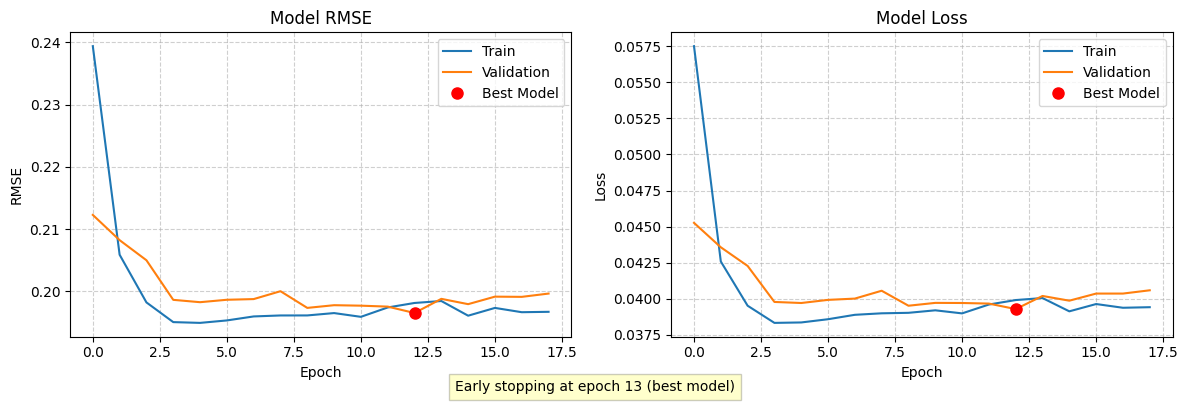

In [ ]:
# Menampilkan grafik pelatihan
plt.figure(figsize=(12, 4))

# Mendapatkan epoch dengan RMSE validasi terendah (model terbaik)
best_epoch = np.argmin(history.history['val_root_mean_squared_error'])

plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], '-')
plt.plot(history.history['val_root_mean_squared_error'], '-')
plt.plot(best_epoch, history.history['val_root_mean_squared_error'][best_epoch], 'ro', markersize=8)
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Best Model'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '-')
plt.plot(history.history['val_loss'], '-')
plt.plot(best_epoch, history.history['val_loss'][best_epoch], 'ro', markersize=8)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Best Model'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.figtext(0.5, 0.01, f"Early stopping at epoch {best_epoch+1} (best model)", 
            ha='center', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.2))
plt.show()

### Testing

In [ ]:
# Membuat fungsi untuk mendapatkan rekomendasi film berdasarkan ID pengguna
def get_movie_recommendations(user_id, top_n=10):
    # Mendapatkan encoding pengguna
    user_encoded = cf_data_processed[cf_data_processed['user_id'] == user_id]['user_encoded'].iloc[0]
    
    # Mendapatkan film yang telah diberi rating oleh pengguna
    movies_rated_by_user = cf_data_processed[cf_data_processed['user_id'] == user_id]['movie_id'].tolist()
    
    # Mendapatkan semua encoding film
    all_movie_encodings = list(range(num_movies))
    
    # Membuat data input untuk prediksi
    user_movie_array = np.array([[user_encoded, movie_encoded] for movie_encoded in all_movie_encodings])
    
    # Mendapatkan prediksi rating
    ratings = model.predict(user_movie_array).flatten()
    
    # Membuat DataFrame dengan ID film, encoding, dan prediksi rating
    movie_ratings = pd.DataFrame({
        'movie_encoded': all_movie_encodings,
        'movie_id': [movie_encoded_to_movie[movie_encoded] for movie_encoded in all_movie_encodings],
        'predicted_rating': ratings
    })
    
    # Menghapus film yang sudah diberi rating oleh pengguna
    recommendations = movie_ratings[~movie_ratings['movie_id'].isin(movies_rated_by_user)]
    
    # Mengurutkan berdasarkan prediksi rating secara menurun
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    # Menggabungkan dengan informasi film untuk mendapatkan judul
    recommendations_with_titles = recommendations.merge(
        movies[['movie_id', 'movie_title']], 
        on='movie_id', 
        how='left'
    )
    
    return recommendations_with_titles.head(top_n)

In [33]:
sample_user_id = 1
user_recommendations = get_movie_recommendations(sample_user_id, top_n=10)
print(f"Top 10 movie recommendations for User {sample_user_id}:")
for idx, row in user_recommendations.iterrows():
    print(f"{row['movie_title']} - Predicted rating: {row['predicted_rating'] * 5:.2f}/5.00")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Top 10 movie recommendations for User 1:
Casablanca (1942) - Predicted rating: 4.31/5.00
One Flew Over the Cuckoo's Nest (1975) - Predicted rating: 4.29/5.00
Manchurian Candidate, The (1962) - Predicted rating: 4.27/5.00
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) - Predicted rating: 4.26/5.00
Boot, Das (1981) - Predicted rating: 4.21/5.00
Schindler's List (1993) - Predicted rating: 4.19/5.00
Chinatown (1974) - Predicted rating: 4.16/5.00
Close Shave, A (1995) - Predicted rating: 4.13/5.00
Thin Man, The (1934) - Predicted rating: 4.11/5.00
Paths of Glory (1957) - Predicted rating: 4.11/5.00


In [34]:
sample_user_id = 21
user_recommendations = get_movie_recommendations(sample_user_id, top_n=10)
print(f"Top 10 movie recommendations for User {sample_user_id}:")
for idx, row in user_recommendations.iterrows():
    print(f"{row['movie_title']} - Predicted rating: {row['predicted_rating'] * 5:.2f}/5.00")

 1/53 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top 10 movie recommendations for User 21:
Wrong Trousers, The (1993) - Predicted rating: 4.01/5.00
Casablanca (1942) - Predicted rating: 3.93/5.00
One Flew Over the Cuckoo's Nest (1975) - Predicted rating: 3.89/5.00
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) - Predicted rating: 3.86/5.00
12 Angry Men (1957) - Predicted rating: 3.83/5.00
Raiders of the Lost Ark (1981) - Predicted rating: 3.80/5.00
To Kill a Mockingbird (1962) - Predicted rating: 3.76/5.00
Empire Strikes Back, The (1980) - Predicted rating: 3.71/5.00
Godfather: Part II, The (1974) - Predicted rating: 3.68/5.00
Shawshank Redemption, The (1994) - Predicted rating: 3.66/5.00
